# imports and loading DataFrame

In [155]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

DATE_FORMAT = "%Y-%m-%dT%H:%M:%S"


# fact table
sessions_df = pd.read_json("data/sessions.jsonl", lines=True)

# dimension tables
deliveries_df = pd.read_json("data/deliveries.jsonl", lines=True)
products_df = pd.read_json("data/products.jsonl", lines=True)
users_df = pd.read_json("data/users.jsonl", lines=True)

# adding a column with time difference in deliveries
adding a column with time difference between purchase_timestamp and delivery_timestamp in deliveries table

1. Cut microseconds from delivery_timestamp, so it will be the same format as purchase_timestamp, because there are no microseconds in purchase_timestamp (using "." as a separator).
2. Change columns format to datetime
3. Add time_diff column (as timedelta64 object).
4. Drop rows where time_diff is null (which means that delivery_timestamp was null).
5. Change type of time_diff from timedelta64 to seconds in float.
6. Drop rows where time_diff is below 0.

In [156]:
# 1.
deliveries_df["delivery_timestamp"] = deliveries_df["delivery_timestamp"].str.split('.', expand=True)[0]

# 2.
deliveries_df["purchase_timestamp"] = pd.to_datetime(deliveries_df["purchase_timestamp"], format=DATE_FORMAT)
deliveries_df["delivery_timestamp"] = pd.to_datetime(deliveries_df["delivery_timestamp"], format=DATE_FORMAT)

# 3.
deliveries_df["time_diff"] = deliveries_df["delivery_timestamp"] - deliveries_df["purchase_timestamp"]

# 4.
deliveries_df = deliveries_df[deliveries_df["time_diff"].notna()]

# 5.
# time diff as duration in seconds
deliveries_df["time_diff"] = deliveries_df["time_diff"].apply(datetime.timedelta.total_seconds)

# 6.
deliveries_df = deliveries_df[deliveries_df["time_diff"] >= 0]


# deliveries_df.info()
# deliveries_df.head()

# join deliveries with sessions

In [157]:
# drop rows where event_type is not equal "BUY_PRODUCT"
sessions_df = sessions_df[sessions_df["event_type"] == "BUY_PRODUCT"]
df = deliveries_df.merge(sessions_df, on="purchase_id", how="left")

# df.info()
# df.head()

In [158]:
# making sure, that timestamp == purchase_timestamp
num_of_rows_before = df.shape[0]
df = df[df["timestamp"] == df["purchase_timestamp"]]
num_of_rows_after = df.shape[0]

assert(num_of_rows_before == num_of_rows_after)

# now we can drop timestamp column, as it is redundant
df = df.drop(columns="timestamp")

# df.info()
# df.head()

# visualizations

## heatmap

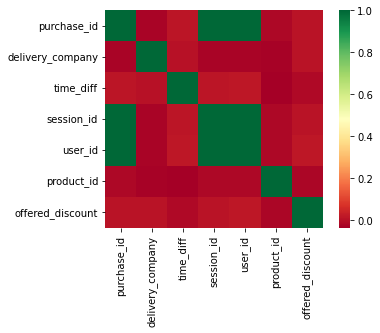

In [159]:
ax = sns.heatmap(df.corr(), square=True, cmap='RdYlGn')


## time_diff histogram

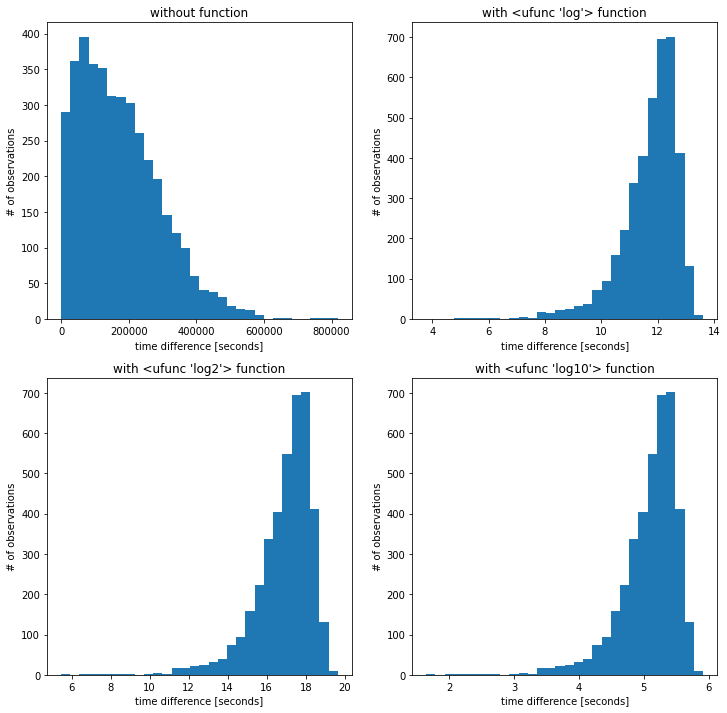

In [160]:
fig, ax = plt.subplots(2, 2)

def plot_hist(x, y, num_bins=30, func=None):
    if func:
        ax[x, y].hist(func(df["time_diff"]), bins=num_bins)
        ax[x, y].set_title(f"with {func} function")
    else:
        ax[x, y].hist(df["time_diff"], bins=num_bins)
        ax[x, y].set_title(f"without function")
    ax[x, y].set_xlabel("time difference [seconds]")
    ax[x, y].set_ylabel("# of observations")

plot_hist(0, 0)
plot_hist(0, 1, func=np.log)
plot_hist(1, 0, func=np.log2)
plot_hist(1, 1, func=np.log10)

fig.set_size_inches([12, 12])
plt.show()

### log of time_diff histogram